In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [2]:
iris = load_iris()
X = iris.data[:, [2, 3]]
target = iris.target[:]

In [3]:
scaler = StandardScaler()
scaler.fit(X)

X_std = scaler.transform(X)

In [4]:
X_train_std, X_test_std, y_train, y_test = train_test_split(
    X_std,
    target,
    random_state=1,
    test_size=0.3,
    stratify=target,
)

In [5]:
class RegressionSoftmaxSGD:
    def __init__(self, n_iter: int, eta: float, random_state: int):
        self.n_iter = n_iter
        self.eta = eta
        self.random_state = random_state

    def net_input(self, x_i):
        return np.dot(self.w_, x_i) + self.b_

    def activation(self, z):
        exp_z = np.exp(np.clip(z, -250, 250))
        sum_exp = exp_z.sum()

        return exp_z / sum_exp

    def _shuffle(self, X, y):
        r = self.rgen_.permutation(len(y))
        return X[r], y[r]

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.classes_count_ = len(self.classes_)
        self.features_count_ = X.shape[1]

        self.rgen_ = np.random.RandomState(seed=self.random_state)

        self.w_ = self.rgen_.normal(
            loc=0.0,
            scale=0.01,
            size=(self.classes_count_, self.features_count_),
        )
        self.b_ = np.zeros(self.classes_count_)

        self.losses_ = []

        for _ in range(self.n_iter):
            losses = 0
            n = len(X)

            X, y = self._shuffle(X, y)

            for x_i, target in zip(X, y):
                net_input = self.net_input(x_i)
                output = self.activation(z=net_input)

                targets = np.where(self.classes_ == target, 1, 0)

                error = targets - output

                for k in range(self.classes_count_):
                    self.w_[k] += self.eta * error[k] * x_i

                self.b_ += self.eta * error

                loss = -np.log(output[target])
                losses += loss

            self.losses_.append(losses / n)

        return self

    def predict_proba(self, X):
        proba = []

        for x_i in X:
            net_input = self.net_input(x_i)
            p = self.activation(net_input)
            proba.append(p)

        return np.array(proba)

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

In [6]:
rs = RegressionSoftmaxSGD(n_iter=10, eta=0.1, random_state=1)
rs.fit(X_train_std, y_train)

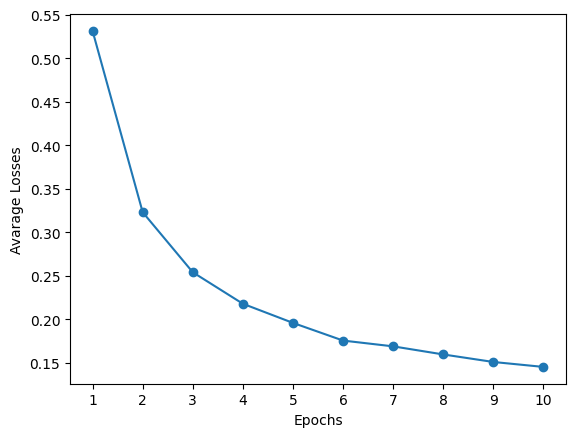

In [7]:
plt.plot(range(1, rs.n_iter + 1), rs.losses_, marker="o")
plt.xticks(range(1, rs.n_iter + 1))
plt.xlabel("Epochs")
plt.ylabel("Avarage Losses")

plt.show()


In [8]:
# Проверка
print("Правильно:", (rs.predict(X_test_std) == y_test).sum())
print("Всего:", len(y_test))

Правильно: 44
Всего: 45


In [9]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    markers = ("o", "s", "^", "v", "<")
    colors = ("red", "blue", "lightgreen", "gray", "cyan")

    cmap = ListedColormap(colors[: len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, resolution),
        np.arange(x2_min, x2_max, resolution),
    )

    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)

    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x=X[y == cl, 0],
            y=X[y == cl, 1],
            alpha=0.8,
            c=colors[cl],
            marker=markers[cl],
            label=f"Class {cl}",
            edgecolor="black",
        )

    if test_idx:
        X_test, _ = X[test_idx, :], y[test_idx]

        plt.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c="none",
            edgecolor="black",
            alpha=1.0,
            linewidth=1,
            marker="o",
            s=100,
            label="Test set",
        )


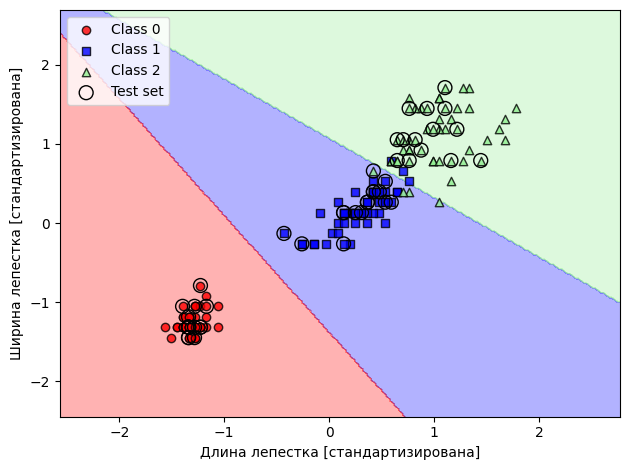

In [10]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X_combined_std, y_combined, rs, test_idx=range(105, 150))
plt.xlabel("Длина лепестка [стандартизирована]")
plt.ylabel("Ширина лепестка [стандартизирована]")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()